In [559]:
# Copied from https://towardsdatascience.com/covid-19-infection-in-italy-mathematical-models-and-predictions
# Modified to make more generic 
# Included hard coded data for Turkey and Ireland

In [560]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline

# Curve Fitting

## 1 - Logistic regression

In [561]:
# The logistic model describes ain infection growth that is going to stop in the future, 

In [562]:
# a refers to the infection speed
# b is the day with the maximum infections occurred
# c is the total number of recorded infected people at the infection’s end
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))



## 2 - Exponential growth

In [563]:
# The exponential model describes an unstoppable infection

In [564]:
def exponential_model(x,a,b,c):
    return a*np.exp(b*(x-c))

## 3 - Generic code for curve fitting

In [565]:
def fit_curve(model_function, x, y, p0):
    fit = curve_fit(model_function, x, y, p0=p0, maxfev=5000)
    # print("fit_result: {}".format(fit))
    a , b, c = fit[0]
    # standard error 
    errors = [np.sqrt(fit[1][i][i]) for i in [0,1,2]]
    return a , b, c, errors

##  4 - Plot & evaluate

In [566]:
# TODO convert func, abc_tuple into struct and pass array of that struct
def plot_curves(x, y, logistic_model_func, abc_tuple_lr, exponential_model_func, abc_tuple_exp):
    
    def calculate_sol(x, logistic_model_func, a_lr, b_lr, c_lr):
        # The expected infection end can be calculated as that particular day at which the cumulative 
        # infected people count is equal to the c parameter rounded to the nearest integer.
        sol = int(fsolve(lambda x : logistic_model_func(x,a_lr,b_lr,c_lr) - int(c_lr),b_lr))
        return sol

    sol = calculate_sol(x, logistic_model_func, abc_tuple_lr[0] , abc_tuple_lr[1], abc_tuple_lr[2])
    pred_x = list(range(max(x),sol))
    plt.rcParams['figure.figsize'] = [7, 7]
    plt.rc('font', size=14)
    # Real data
    plt.scatter(x,y,label="Real data",color="red")
    
    # Predicted logistic curve
    plt.plot(x+pred_x, 
             [logistic_model_func(i, abc_tuple_lr[0] , abc_tuple_lr[1], abc_tuple_lr[2]) for i in x+pred_x], 
             label="Logistic model" )
    # Predicted exponential curve
    plt.plot(x+pred_x, 
             [exponential_model_func(i, abc_tuple_exp[0] , abc_tuple_exp[1], abc_tuple_exp[2]) for i in x+pred_x], 
             label="Exponential model" )
    plt.legend()
    plt.xlabel("Days since 1 January 2020")
    plt.ylabel("Total number of infected people")
    plt.ylim((min(y)*0.9,abc_tuple_lr[2]*1.1))
    plt.show()

In [567]:
# Lower Mean Squared Error between theoretical and experimental data, the better the fit.
def calculate_mse(x, y, logistic_model_func, abc_tuple_lr, exponential_model_func, abc_tuple_exp):
    y_pred_logistic = [logistic_model_func(i, abc_tuple_lr[0] , abc_tuple_lr[1], abc_tuple_lr[2]) for i in x]
    y_pred_exp =  [exponential_model_func(i, abc_tuple_exp[0] , abc_tuple_exp[1], abc_tuple_exp[2]) for i in x]
    mse_lr = mean_squared_error(y,y_pred_logistic)
    mse_exp = mean_squared_error(y,y_pred_exp)
    return mse_lr, mse_exp

# Execute logistic regression & exponential growth

## 1 - Data on Italy

### 1.1 - Load data

In [568]:
url = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
df = pd.read_csv(url)

In [569]:
df.head()

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi
0,2020-02-24 18:00:00,ITA,101,26,127,94,221,221,1,7,229,4324
1,2020-02-25 18:00:00,ITA,114,35,150,162,311,90,1,10,322,8623
2,2020-02-26 18:00:00,ITA,128,36,164,221,385,74,3,12,400,9587
3,2020-02-27 18:00:00,ITA,248,56,304,284,588,203,45,17,650,12014
4,2020-02-28 18:00:00,ITA,345,64,409,412,821,233,46,21,888,15695


In [570]:
df = df.loc[:,['data','totale_casi']]
FMT = '%Y-%m-%d %H:%M:%S'
date = df['data']
df['data'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01 00:00:00", FMT)).days  )

In [571]:
df.head()

,data,totale_casi
0,54,229
1,55,322
2,56,400
3,57,650
4,58,888


In [572]:
# Data
x = list(df.iloc[:,0])
y = list(df.iloc[:,1])

In [573]:
# p0: Initial guess for the parameters (length N)
p0_lr = [2,100,20000] # i.e. peak (b) after 46 days, %0.033 of the population (60.48 million)
p0_exp = [1,1,1]

### 1.2 - Execute Logistic Regression

In [574]:
# Logistic Regression
a_lr , b_lr, c_lr, errors_lr = fit_curve(logistic_model, x, y, p0=p0_lr)
print("a_lr:{} , b_lr:{}, c_lr:{} ".format(a_lr , b_lr, c_lr))
print("errors_lr: {}".format(errors_lr))


a_lr:4.634966629489467 , b_lr:77.65365624717248, c_lr:77924.86572783628 
errors_lr: [0.09804174568542999, 0.43664952432814563, 3910.3712549477614]


In [575]:
# The expected infection end can be calculated as that particular day at which the cumulative 
# infected people count is equal to the c parameter rounded to the nearest integer.
sol = int(fsolve(lambda x : logistic_model(x,a_lr,b_lr,c_lr) - int(c_lr),b_lr))
print(sol) 

130


In [576]:
# checked from https://asd.gsfc.nasa.gov/Craig.Markwardt/doy2019.html
# sol = 130 --> May 10 

### 1.3 - Execute Exponential Growth

In [577]:
# Exponential Growth
a_exp , b_exp, c_exp, errors_exp = fit_curve(exponential_model,x,y,p0=p0_exp)
print("a_exp:{} , b_exp:{}, c_exp:{} ".format(a_exp , b_exp, c_exp))
print("errors_exp: {}".format(errors_exp))

a_exp:2.186624980172888 , b_exp:0.1564296208594573, c_exp:14.83378122103667 
errors_exp: [1570851.6582598905, 0.005392611760740287, 4592421.750165852]


### 1.4 - Plot

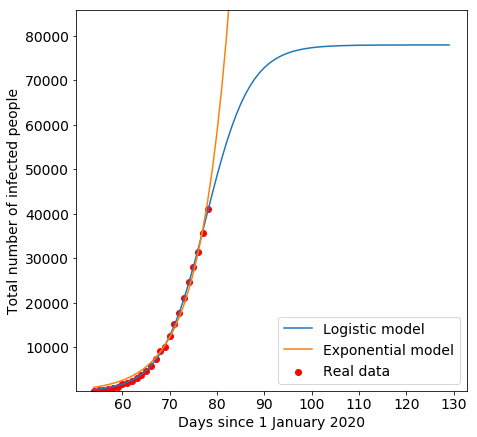

In [578]:
plot_curves(x, y, logistic_model, (a_lr, b_lr, c_lr), exponential_model, (a_exp, b_exp, c_exp))

### 1.5 - Evaluate

In [579]:
# Lower Mean Squared Error between theoretical and experimental data, the better the fit.

In [580]:
mse_lr, mse_exp = calculate_mse(x, y, logistic_model, (a_lr, b_lr, c_lr), 
                                exponential_model, (a_exp, b_exp, c_exp))
print("Logistic model MSE: {}".format(mse_lr))
print("Exponential model MSE: {}".format(mse_exp))

Logistic model MSE: 84725.59616701226
Exponential model MSE: 971991.2500208962


## 2 - Data on Republic of Ireland

### 2.1 - Load data

In [581]:
# TODO Get data automatically from some source
# Starts from Feb 29, to March 19
total_cases = [1, 1, 1, 2 , 6, 13, 18, 19, 21, 24, 34, 43, 70, 90, 129, 169, 223, 292, 366, 557]
dates = list(range(60, 80))

In [582]:
# Data
x = dates
y = total_cases

In [583]:
# lr params
# a refers to the infection speed
# b is the day with the maximum infections occurred
# c is the total number of recorded infected people at the infection’s end

# p0: Initial guess for the parameters (length N)
p0_lr = [2,106,1597] # i.e. peak (b) after 46 days, %0.033 of the population(4.83 million)
p0_exp = [1,1,1]

### 2.2 - Execute Logistic Regression

In [584]:
# Logistic Regression
a_lr , b_lr, c_lr, errors_lr = fit_curve(logistic_model, x, y, p0=p0_lr)
print("a_lr:{} , b_lr:{}, c_lr:{} ".format(a_lr , b_lr, c_lr))
print("errors_lr: {}".format(errors_lr))


a_lr:3.3286654735328796 , b_lr:120.12436367084497, c_lr:124802948.20868069 
errors_lr: [0.26681478330040825, 117429.73871470847, 4395849555503.055]


In [585]:
# The expected infection end can be calculated as that particular day at which the cumulative 
# infected people count is equal to the c parameter rounded to the nearest integer.
sol = int(fsolve(lambda x : logistic_model(x,a_lr,b_lr,c_lr) - int(c_lr),b_lr))
print(sol) 

187


In [586]:
# checked from https://asd.gsfc.nasa.gov/Craig.Markwardt/doy2020.html
# sol = 187 --> July 7, 2020 

### 2.3 - Execute Exponential Growth

In [587]:
# Exponential Growth
a_exp , b_exp, c_exp, errors_exp = fit_curve(exponential_model,x,y,p0=p0_exp)
print("a_exp:{} , b_exp:{}, c_exp:{} ".format(a_exp , b_exp, c_exp))
print("errors_exp: {}".format(errors_exp))

a_exp:8.388149316897843e-07 , b_exp:0.3004200631858777, c_exp:11.498152589067294 
errors_exp: [0.40232581798066946, 0.009869414237724722, 1596552.4465971126]


### 2.4 - Plot

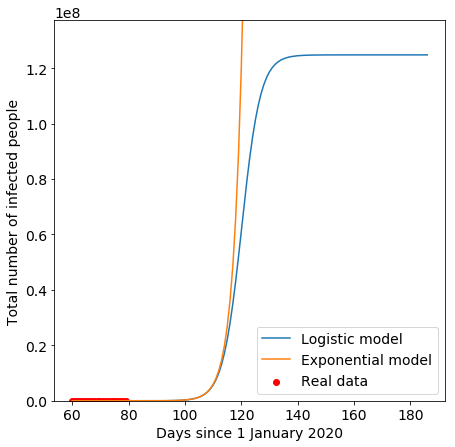

In [588]:
plot_curves(x, y, logistic_model, (a_lr, b_lr, c_lr), exponential_model, (a_exp, b_exp, c_exp))

### 2.5 - Evaluate

In [589]:
# Lower Mean Squared Error between theoretical and experimental data, the better the fit.
mse_lr, mse_exp = calculate_mse(x, y, logistic_model, (a_lr, b_lr, c_lr), 
                                exponential_model, (a_exp, b_exp, c_exp))
print("Logistic model MSE: {}".format(mse_lr))
print("Exponential model MSE: {}".format(mse_exp))

Logistic model MSE: 87.53447040565155
Exponential model MSE: 87.53390466842501


## 3 - Data on Turkey

### 3.1 - Load data

In [590]:
# TODO Get data automatically from some source
# Starts from March 11 29, to March 19
total_cases = [1, 2, 5, 6, 18, 47, 98, 191, 358]
dates = list(range(71, 80))

In [591]:
# Data
x = dates
y = total_cases

In [592]:
# lr params
# a refers to the infection speed
# b is the day with the maximum infections occurred
# c is the total number of recorded infected people at the infection’s end

# p0: Initial guess for the parameters (length N)
p0_lr = [2,117,26723] # i.e. peak (b) after 46 days, c=~%0.033 of the population(80.81 million)
p0_exp = [1,1,1]

### 3.2 - Execute Logistic Regression

In [593]:
# Logistic Regression
a_lr , b_lr, c_lr, errors_lr = fit_curve(logistic_model, x, y, p0=p0_lr)
print("a_lr:{} , b_lr:{}, c_lr:{} ".format(a_lr , b_lr, c_lr))
print("errors_lr: {}".format(errors_lr))


a_lr:1.2615241429282704 , b_lr:80.11200910957808, c_lr:1221.2589048987472 
errors_lr: [0.04945354256534696, 0.3706775586376204, 227.4783012608654]


In [594]:
# The expected infection end can be calculated as that particular day at which the cumulative 
# infected people count is equal to the c parameter rounded to the nearest integer.
sol = int(fsolve(lambda x : logistic_model(x,a_lr,b_lr,c_lr) - int(c_lr),b_lr))
print(sol) 

90


In [595]:
# checked from https://asd.gsfc.nasa.gov/Craig.Markwardt/doy2020.html
# sol = 90 --> March 30, 2020 

### 3.3 - Execute Exponential Growth

In [596]:
# Exponential Growth
a_exp , b_exp, c_exp, errors_exp = fit_curve(exponential_model,x,y,p0=p0_exp)
print("a_exp:{} , b_exp:{}, c_exp:{} ".format(a_exp , b_exp, c_exp))
print("errors_exp: {}".format(errors_exp))

a_exp:9.033403145777513e-17 , b_exp:0.6655030466433658, c_exp:14.641619410161102 
errors_exp: [nan, 0.017309190017961242, nan]


/Users/mgozsoy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


### 3.4 - Plot

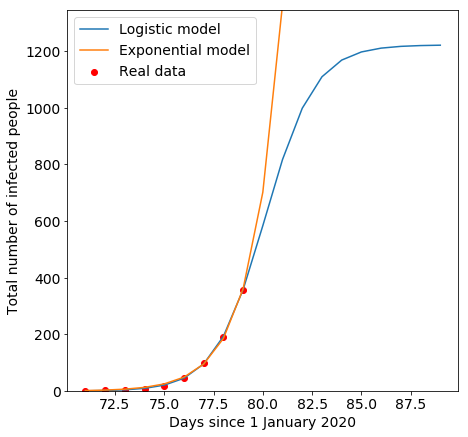

In [597]:
plot_curves(x, y, logistic_model, (a_lr, b_lr, c_lr), exponential_model, (a_exp, b_exp, c_exp))

### 3.5 - Evaluate

In [598]:
# Lower Mean Squared Error between theoretical and experimental data, the better the fit.
mse_lr, mse_exp = calculate_mse(x, y, logistic_model, (a_lr, b_lr, c_lr), 
                                exponential_model, (a_exp, b_exp, c_exp))
print("Logistic model MSE: {}".format(mse_lr))
print("Exponential model MSE: {}".format(mse_exp))

Logistic model MSE: 3.7793851085106485
Exponential model MSE: 17.207396981107948
